# **Capitulo 5 – Time Series**

# Setup

Como hicimos en NoteBooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas

In [20]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

Y vamos a crear la carpeta `images/time_series` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este cuaderno para guardar las figuras:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "time_series"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Time Series

**La previsión** es quizá la aplicación más común del Machine Learning en el mundo real. Las empresas pronostican la demanda de productos, los gobiernos prevén el crecimiento económico y demográfico, los meteorólogos predicen el tiempo. La comprensión de lo que está por venir es una necesidad urgente en la ciencia, la administración y la industria (¡por no hablar de nuestra vida personal!), y los profesionales de estos campos aplican cada vez más el Machine LEarning para dar respuesta a esta necesidad.

La previsión de series temporales es un campo amplio con una larga historia. Este NoteBook se centra en la aplicación de métodos modernos del Machine Learning a los datos de series temporales con el objetivo de producir las predicciones más precisas.

# ¿Qué es una serie temporal?

El objeto básico de la previsión es la **serie temporal**, que es un conjunto de observaciones registradas a lo largo del tiempo. En las aplicaciones de previsión, las observaciones suelen registrarse con una frecuencia regular, como diaria o mensual.

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns

from sklearn.linear_model import LinearRegression

from warnings import simplefilter
simplefilter("ignore")

c:\Users\jamr1\miniconda3\envs\gym2\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
C:\Users\jamr1\AppData\Local\Temp\ipykernel_14036\486711488.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
df = pd.read_csv(
    "data/book_sales.csv",
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)

df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


Esta serie registra el número de ventas de libros de tapa dura en una tienda minorista durante 30 días. Observe que tenemos una única columna de observaciones `Tapa dura` con un índice temporal `Fecha`.

# Regresión lineal con series temporales

En la primera parte de este NoteBook, utilizaremos el algoritmo de regresión lineal para construir modelos de previsión. La regresión lineal es ampliamente utilizada en la práctica y se adapta de forma natural incluso a tareas de previsión complejas.

El algoritmo de **regresión lineal** aprende a hacer una suma ponderada de sus características de entrada. Para dos características, tendríamos

```
objetivo = peso_1 * característica_1 + peso_2 * característica_2 + bias
```

Durante el entrenamiento, el algoritmo de regresión aprende los valores de los parámetros "peso_1", "peso_2" y "sesgo" que mejor se ajustan al "objetivo". (Este algoritmo suele denominarse *mínimos cuadrados ordinarios*, ya que elige los valores que minimizan el error cuadrático entre el objetivo y las predicciones). Los pesos también se denominan *coeficientes de regresión* y el `bias` también se denomina *intercepto* porque indica dónde cruza la gráfica de esta función el eje y.

### Características del paso del tiempo

Existen dos tipos de características exclusivas de las series temporales: las características de paso de tiempo y las características de retardo.

Las características de paso de tiempo son características que podemos derivar directamente del índice de tiempo. La característica de paso de tiempo más básica es el **dummy de tiempo**, que cuenta los pasos de tiempo en la serie desde el principio hasta el final.

In [5]:
df['Time'] = np.arange(len(df.index))

df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


La regresión lineal con la variable ficticia del tiempo produce el modelo:

```
objetivo = peso * tiempo + sesgo
```

La variable ficticia de tiempo nos permite ajustar curvas a series temporales en un *trazado de tiempo*, donde `Time` forma el eje x.

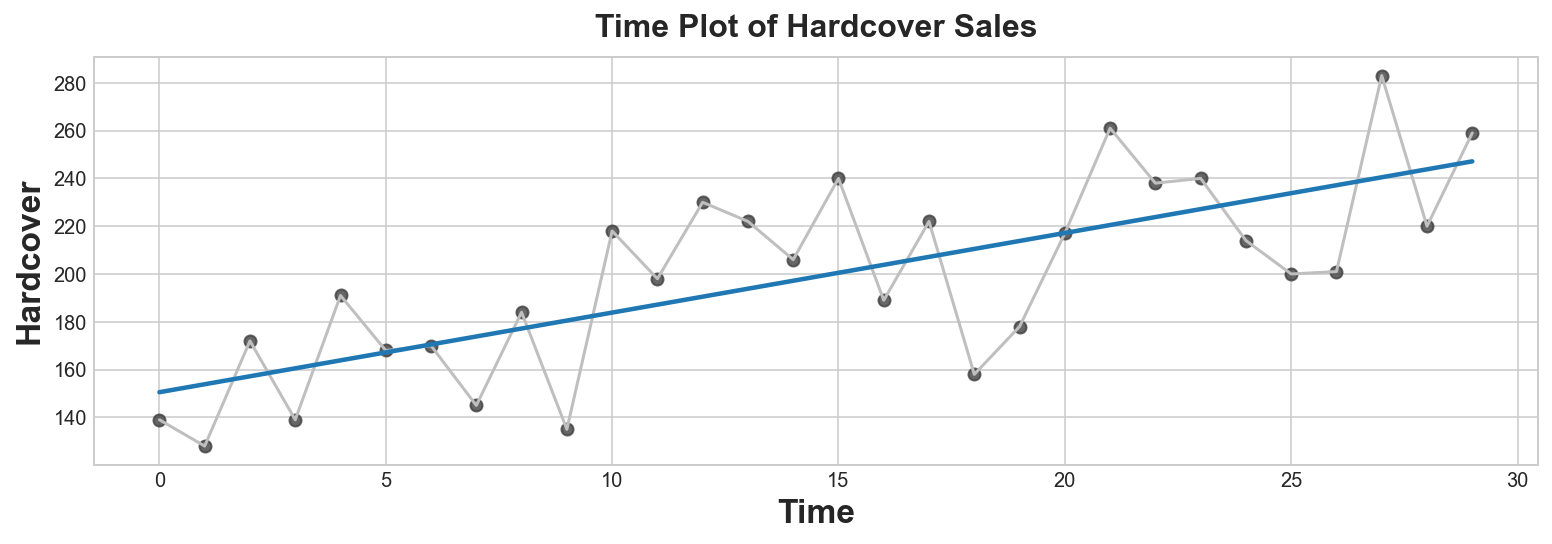

In [8]:
fig, ax = plt.subplots()
ax.plot(df['Time'].values, df['Hardcover'].values, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

Las funciones de paso del tiempo permiten modelar la **dependencia del tiempo**. Una serie es dependiente del tiempo si sus valores pueden predecirse a partir del momento en que se produjeron. En la serie *Ventas de libros de tapa dura*, podemos predecir que las ventas de finales de mes suelen ser superiores a las de principios de mes.

### Lag features

Para crear una **Lag features**, desplazamos las observaciones de la serie objetivo para que parezcan haber ocurrido más tarde en el tiempo. Aquí hemos creado una función de desfase de 1 paso, aunque también es posible desplazarla varios pasos.

In [9]:
df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


La regresión lineal con una Lag features produce el modelo:

```
target = weight * lag + bias
```

Así pues, las Lag features nos permiten ajustar curvas a *lags plots* en los que cada observación de una serie se traza con respecto a la observación anterior.

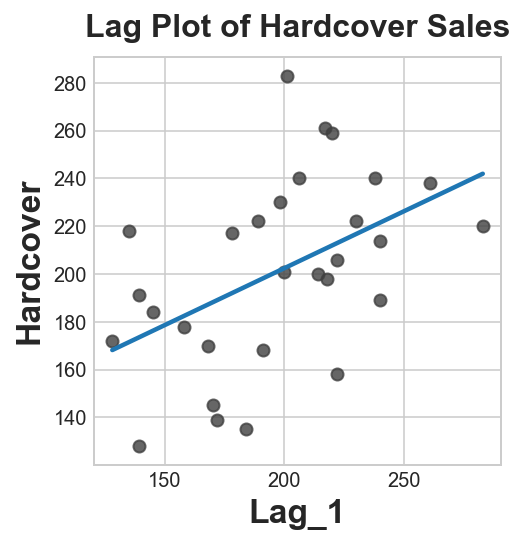

In [10]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

En el gráfico de lag se puede ver que las ventas de un día (`Hardcover`) están correlacionadas con las ventas del día anterior (`Lag_1`). Cuando se observa una relación de este tipo, se sabe que una función de desfase será útil.

En términos más generales, las funciones de lag permiten modelar la **dependencia serial**. Una serie temporal tiene dependencia serial cuando una observación puede predecirse a partir de observaciones previas. En *Ventas de Tapa Dura*, podemos predecir que las ventas altas de un día suelen significar ventas altas al día siguiente.

---

La adaptación de algoritmos de aprendizaje automático a problemas de series temporales consiste en gran medida en el feature engineer con el índice temporal y los lags. Para la mayor parte del NoteBook, utilizamos la regresión lineal por su simplicidad, pero estas características serán útiles sea cual sea el algoritmo que elija para su tarea de previsión.

# Ejemplo - Tráfico en túneles

*Tunnel Traffic* es una serie temporal que describe el número de vehículos que atraviesan cada día el túnel de Baregg, en Suiza, desde noviembre de 2003 hasta noviembre de 2005. En este ejemplo, obtendremos algo de práctica aplicando la regresión lineal a características de paso de tiempo y características de retardo.

In [11]:
data_dir = Path("data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])

# Crear una serie temporal en Pandas estableciendo el índice a una columna de fecha.
# Parseamos "Day" como un tipo de fecha usando `parse_dates` cuando cargamos los datos.

tunnel = tunnel.set_index("Day")

# Por defecto, Pandas crea un `DatetimeIndex` con dtype `Timestamp`
# (equivalente a `np.datetime64`, representando una serie temporal como una
# secuencia de medidas tomadas en momentos únicos. Un `PeriodIndex`,
# por otro lado, representa una serie temporal como una secuencia de
# cantidades acumuladas durante periodos de tiempo. Los periodos suelen ser
# más fáciles de trabajar, así que es lo que usaremos.
tunnel = tunnel.to_period()

tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


### Función de paso de tiempo

Siempre que la serie temporal no tenga fechas missing, podemos crear un paso de tiempo contando la longitud de la serie.

In [12]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


El procedimiento para ajustar un modelo de regresión lineal sigue los pasos estándar de scikit-learn.

In [13]:
X = df.loc[:, ['Time']]
y = df.loc[:, 'NumVehicles']

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

El modelo realmente creado es (aproximadamente) `Vehículos = 22,5 * Tiempo + 98176`. El trazado de los valores ajustados a lo largo del tiempo nos muestra cómo el ajuste de la regresión lineal a la variable ficticia del tiempo crea la línea de tendencia definida por esta ecuación.

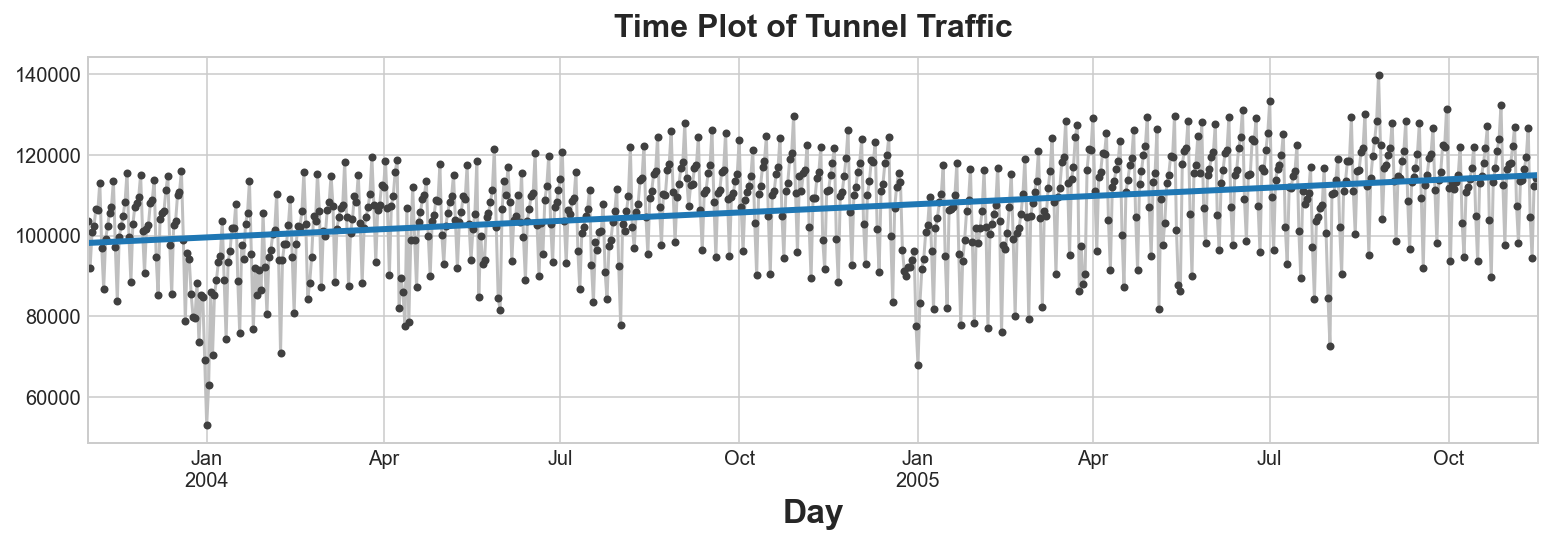

In [14]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

### Lag feature

Pandas nos proporciona un método sencillo para retrasar una serie, el método `shift`.

In [15]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


Al crear características de lags, tenemos que decidir qué hacer con los valores que faltan. Una opción es rellenarlos con 0,0 o con el primer valor conocido. En su lugar, simplemente eliminaremos los valores que faltan, asegurándonos de eliminar también los valores en el objetivo de las fechas correspondientes.

In [16]:
X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True) 
y = df.loc[:, 'NumVehicles']
y, X = y.align(X, join='inner')

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

El gráfico de lags nos muestra lo bien que hemos sido capaces de ajustar la relación entre el número de vehículos de un día y el del día anterior.

Text(0.5, 1.0, 'Lag Plot of Tunnel Traffic')

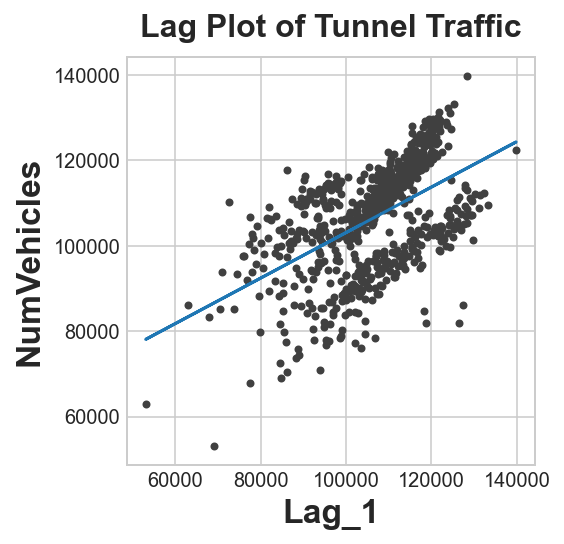

In [18]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'].values, y.values, '.', color='0.25')
ax.plot(X['Lag_1'].values, y_pred.values)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic')

¿Qué significa esta predicción a partir de una característica de lag sobre lo bien que podemos predecir la serie a lo largo del tiempo? El siguiente gráfico temporal nos muestra cómo responden ahora nuestras previsiones al comportamiento de la serie en el pasado reciente.

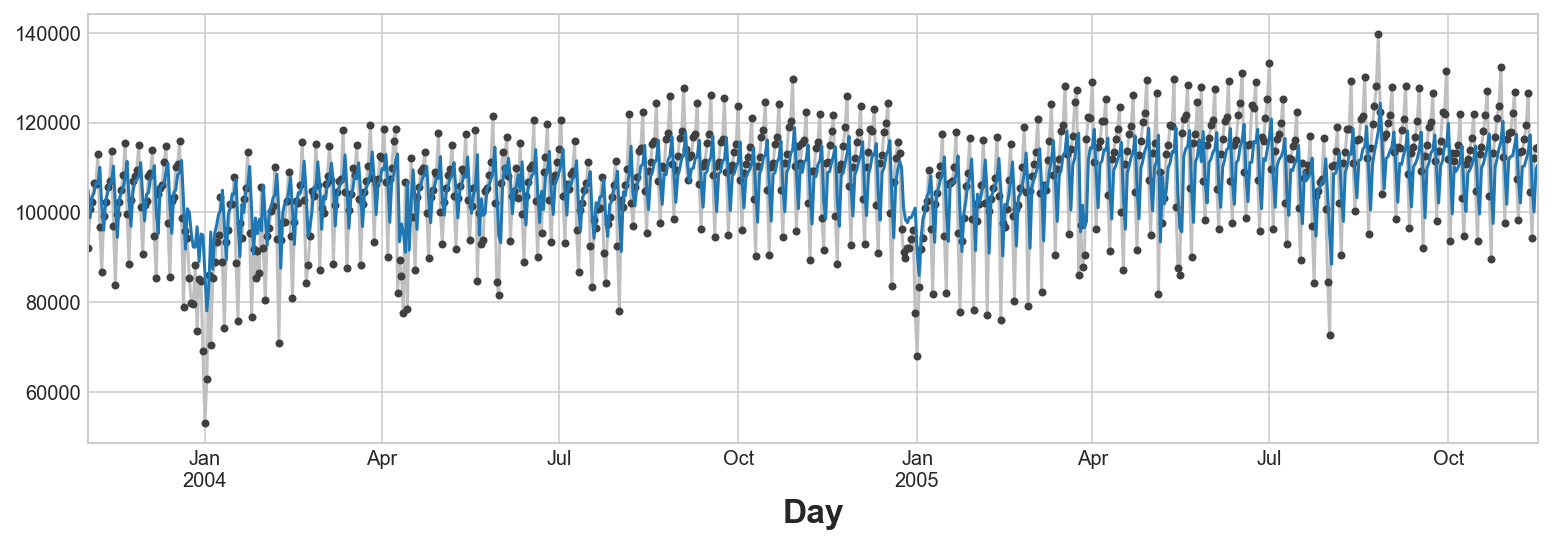

In [19]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

Los mejores modelos de series temporales suelen incluir alguna combinación de características de paso temporal y características de lags. En los próximos NoteBooks, aprenderemos a diseñar características que modelen los patrones más comunes de las series temporales utilizando las características de esta lección como punto de partida.